In [27]:
import pdb
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from ipywidgets import widgets, Checkbox, FloatSlider, IntSlider, IntRangeSlider, FloatRangeSlider, RadioButtons
from IPython.core.display import clear_output, display
%matplotlib inline

# Calibrate

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../calibration-elp-final/WIN*.jpg')[0:9]

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
#         cv2.imshow('img', img)
#         cv2.waitKey(500)

cv2.destroyAllWindows()

print("Number of calibration images: {}".format(len(images)))
print(images)

Number of calibration images: 9
['../calibration-elp-final/WIN_20170604_18_18_01_Pro.jpg', '../calibration-elp-final/WIN_20170604_18_19_00_Pro.jpg', '../calibration-elp-final/WIN_20170606_02_25_41_Pro.jpg', '../calibration-elp-final/WIN_20170604_18_17_12_Pro.jpg', '../calibration-elp-final/WIN_20170604_18_18_55_Pro.jpg', '../calibration-elp-final/WIN_20170606_02_28_01_Pro.jpg', '../calibration-elp-final/WIN_20170606_02_24_43_Pro.jpg', '../calibration-elp-final/WIN_20170604_18_16_51_Pro.jpg', '../calibration-elp-final/WIN_20170606_02_27_55_Pro.jpg']


Return of calibrate camera: 0.26600119293689817


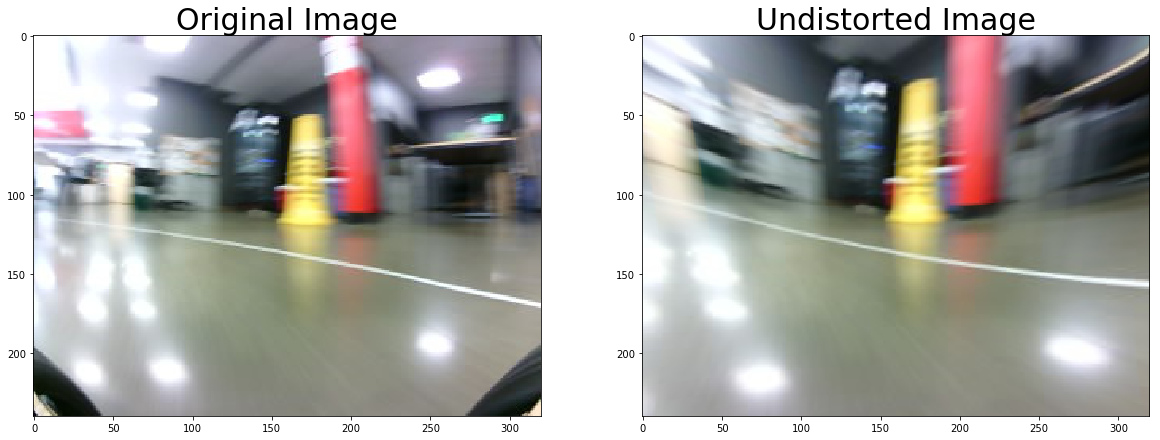

In [4]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('test_images/turning.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

print("Return of calibrate camera: {}".format(ret))
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration-elp-final/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "../calibration-elp-final/cal-elp.p", "wb" ) )
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Perspective Transform

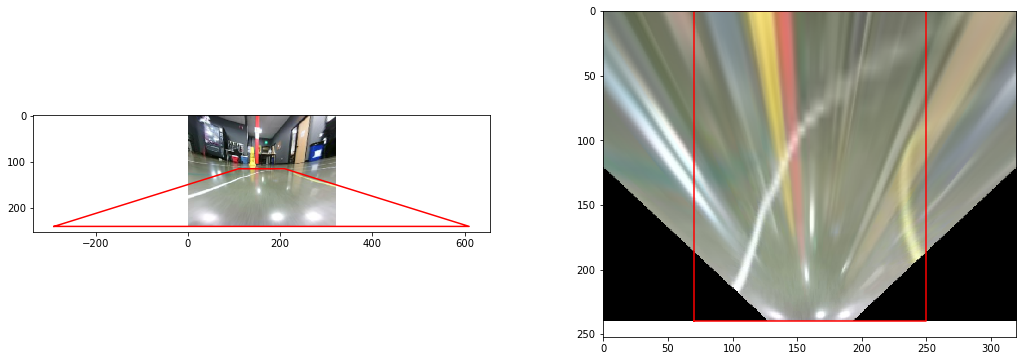

In [211]:
fig = plt.figure(figsize=(18, 6))

img = cv2.imread('test_images/middle.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


img_size = (img.shape[1], img.shape[0])

top_width = 100
left_top = (img_size[0] - top_width) / 2
right_top = left_top + top_width
bottom_width = 900
left_bottom = (img_size[0] - bottom_width) / 2
right_bottom = left_bottom + bottom_width
top = 115
bottom = 240

src = np.float32([[left_bottom,bottom],
                 [left_top,top],
                 [right_top,top],
                 [right_bottom,bottom]])

width = 180
left = (img_size[0] - width) / 2
right = left + width
top = 0
bottom = 240
dst = np.float32([[left,bottom],
                 [left,top],
                 [right,top],
                 [right,bottom]])

a = fig.add_subplot(1, 2, 1)
undist_img = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist_img)
a.plot(np.append(src[:,0],src[0,0]), np.append(src[:,1],src[0,1]), '-r')

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(undist_img, M, img_size)

a = fig.add_subplot(1, 2, 2)
plt.imshow(warped)
_ = a.plot(np.append(dst[:,0],dst[0,0]), np.append(dst[:,1],dst[0,1]), '-r')

# Reflections removal

See "Reflection Removal" notebook document.

In [1]:
img_paths = glob.glob('test_images/*.jpg')
fig = plt.figure(figsize=(15, 20))
cols = 4
rows = len(img_paths)
i = 1

def preprocess(img_raw, mtx, dist, M):
    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2HSV)[:, :, 1]
    img = cv2.Sobel(img, -1, 1, 0, ksize=3)
    img = img > 127
    
    img1 = cv2.cvtColor(img_raw, cv2.COLOR_BGR2HSV)[:, :, 2]
    img1 = cv2.Sobel(img1, -1, 0, 1, ksize=3)
    img1 = img1 > 127
    
    img2 = cv2.cvtColor(img_raw, cv2.COLOR_BGR2HSV)
    img2 = cv2.inRange(img2, (38, 61, 112), (139, 255, 255))
    img2 = img2 > 25.5

    final_img = (img==1) | (img1==1) | (img2==1)
    
    f3 = np.stack((final_img, final_img, final_img), axis=2)
    f3 = (f3 * 255.0).astype(np.uint8)

    undist = cv2.undistort(f3, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped[:, :, 0]

for img_path in img_paths:
    ax = fig.add_subplot(rows, cols, i)
    img_raw = cv2.imread(img_path)
    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
#     warped = cv2.warpPerspective(undist, M, img_size)
    plt.imshow(undist)
    i += 1

    ax = fig.add_subplot(rows, cols, i)
    warped = preprocess(img_raw, mtx, dist, M)
    plt.imshow(warped, cmap='gray')
    i += 1

NameError: name 'glob' is not defined

# Histogram

In [303]:
importance = 1
weights = np.array([range(5)])*importance
print(weights.T)
x = np.array([[0, 1, 1, 0, 1, 0],
              [0, 1, 1, 1, 0, 1],
              [0, 0, 1, 0, 1, 1],
              [0, 1, 1, 1, 0, 0],
              [1, 1, 0, 1, 1, 0]])
x = weights.T ** x
print(x)

# For center weights, convert as follows:
# 0 1 2 3 4 5 6 7 to 1 2 3 4 4 3 2 1
# (changes: 1, 1, 1, 1, 0, -2, -4. -6)
# In other words, points closer to the center have higher scores.

cweights = np.array([range(6)])
hlen = int(cweights.shape[1]/2) # half-length
adj = [1] * hlen # adjustments
for i in range(hlen):
    v = -i*6
    adj.append(v)
cweights += adj
print(cweights)
x += cweights
print(x)
histogram = np.sum(x[1:,:], axis=0)
histogram

[[0]
 [1]
 [2]
 [3]
 [4]]
[[1 0 0 1 0 1]
 [1 1 1 1 1 1]
 [1 1 2 1 2 2]
 [1 3 3 3 1 1]
 [4 4 1 4 4 1]]
[[ 1  2  3  3 -2 -7]]
[[ 2  2  3  4 -2 -6]
 [ 2  3  4  4 -1 -6]
 [ 2  3  5  4  0 -5]
 [ 2  5  6  6 -1 -6]
 [ 5  6  4  7  2 -6]]


array([ 11,  17,  19,  21,   0, -23])

In [342]:
def distance_between_lanes(leftx, rightx, xm_per_pix=1):
    return abs(rightx - leftx) * xm_per_pix

def calculate_curvature_radius(left_fit, right_fit, leftx, rightx, ploty, xm_per_pix, ym_per_pix):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad_m = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad_m = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters

    return (left_curverad, right_curverad, left_curverad_m, right_curverad_m)

def lines_are_parallel(line1_fit, line2_fit, threshold=(0, 0)):
    """ Check if two lines are parallel by comparing their coefficients.
    """
    a_diff = np.abs(line1_fit[0] - line2_fit[0])
    b_diff = np.abs(line1_fit[1] - line2_fit[1])
    
    # Keep the print commands for debugging.
#     print("checking parallelism")
#     print("line 1 a: {}, b: {}".format(line1_fit[0], line1_fit[1]))
#     print("line 2 a: {}, b: {}".format(line2_fit[0], line2_fit[1]))
#     print("diff   a: {}, b: {}".format(a_diff, b_diff))
#     print("thres  a: {}, b: {}".format(threshold[0], threshold[1]))
#     print("parallel? {}".format((a_diff < threshold[0] and b_diff < threshold[1])))

    return(a_diff < threshold[0] and b_diff < threshold[1])

def lines_are_plausible(left, right, parallel_threshold=(0,0), dist_threshold=(0,0), minpix=3, xm_per_pix=1):
    """
    left: A tuple of left x pixel positions and polyfit tuple.
    right: A tuple of right x pixel positions and polyfit tuple.
    """
    left_fitx = left[0]
    left_fit = left[1]
    right_fitx = right[0]
    right_fit = right[1]
    is_parallel = lines_are_parallel(left_fit, right_fit, threshold=parallel_threshold)
    dist = distance_between_lanes(left_fitx[-1], right_fitx[-1], xm_per_pix=xm_per_pix)
    is_plausible_dist = dist_threshold[0] < dist < dist_threshold[1]

    return is_parallel & is_plausible_dist

def annotate_with_lines(background, lines, keep_background=True):
    """ Annotate a background with lines. """
    # Remove empty lines
    lines = list(filter(lambda line: line is not None, lines))
    ploty = [i for i in range(background.shape[0])]
    # Create an image to draw the lines on
    if keep_background:
        canvas = np.array(background, dtype=np.uint8)
    else:
        canvas = np.zeros_like(background).astype(np.uint8)

    canvas = np.stack((canvas, canvas, canvas), axis=2)
    canvas = (canvas * 255.0).astype(np.uint8)

    print("Red: left, Green: right")
    colors = [(255, 0, 0), (0, 255, 10)]
    for i, fitx in enumerate(lines):
        # Recast the points into usable format for cv2.fillPoly()
        pts = np.array([np.transpose(np.vstack([fitx, ploty]))], np.int32)
        cv2.polylines(canvas, np.int_([pts]), False, colors[i], thickness=3)
    return canvas

def calc_error(fitx, nonzero):
    """ Calculate the similarity score of line positions and activated pixels.
    Args:
        fitx: The line's x value for each y position.
        nonzero: Non-zero pixels produced by np.nonzero() method.
    """
    # Identify the x and y positions of all nonzero pixels in the image
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    fitx_int = np.array(fitx, dtype=np.uint8)
    
    total_error = 0
    for y, x in enumerate(fitx_int):
        min_error = None
        # Indexes of active pixels where y == some value
        for [i] in np.argwhere(nonzeroy==y):
            # Compare the line's x with the pixel's.
            error = (nonzerox[i] - x)**2
            if min_error is None or error < min_error:
                min_error = error
        if min_error is None:
            min_error = 0
        total_error += min_error
    
    return total_error


In [382]:
class FindLinesSlidingWindows(object):
    def __init__(self,
                 debug=False,
                 xm_per_pix=3.7/700, ym_per_pix=30/720,
                 parallel_threshold=(0.0003, 0.55),
                 # distance in meters
                 # https://en.wikipedia.org/wiki/Lane#Lane_width
                 # The widths of vehicle lanes typically vary from 9 to 15 feet (2.7 to 4.6 m).
                 dist_threshold=(2.7, 4.6),
                 alpha=1.,
                 nwindows=20,
                 window_minpix=50,
                 lane_minpix=3,
                 subsequent_search_margin=30, always_recalculate=False):
        self.reset()

        self.xm_per_pix = xm_per_pix
        self.ym_per_pix = ym_per_pix        
        
        # Initial search windows
        self.alpha = alpha
        self.nwindows = nwindows
        self.window_minpix = window_minpix
        
        # Subsequent search related
        self.subsequent_search_margin = subsequent_search_margin
        self.always_recalculate = always_recalculate
        
        # Check if lanes are reasonable
        self.lane_minpix = lane_minpix
        self.parallel_threshold = parallel_threshold
        self.dist_threshold = dist_threshold
        
        self.debug = debug
    
    def _fitpoly(self, x, y):
        # Fit a second order polynomial
        if len(y) > 0 and len(x) > 0:
            fit = np.polyfit(y, x, 2)
        else:
            return None
        if all( i==0 for i in fit ):
            return None
        return fit
    
    def _calculate_v_fits(self, binary_warped):
        """ Find lines that run vertically on the screen.
        """
        # binary_warped shape: (height, width)
        
        left_lane_inds = []
        right_lane_inds = []
        
        margin = self.subsequent_search_margin

        # Pixels closer to the car are more important, so we apply weights the histogram
        importance = 1.1
        weights = np.array([range(binary_warped.shape[0])])*importance
        weighted = binary_warped * weights.T
#         weighted = weights.T ** binary_warped
#         weighted = binary_warped

        # For center weights, convert as follows:
        # 0 1 2 3 4 5 6 7 to 1 2 3 4 4 3 2 1
        # (changes: 1, 1, 1, 1, 0, -2, -4. -6)
        # In other words, points closer to the center have higher scores.

        cweights = np.array([range(binary_warped.shape[1])])
        hlen = int(cweights.shape[1]/2) # half-length
        adj = [1] * hlen # adjustments
        for i in range(hlen):
            v = -i*2
            adj.append(v)
        cweights += adj
        weighted *= cweights * 2

        # Sums all weighted points in the bottom 50% section (remember that bigger numbers are at the bottom).
#         histogram = np.sum(weighted, axis=0)
        histogram = np.sum(weighted[int(weighted.shape[0]/2):,:], axis=0)
        midpoint = np.int(histogram.shape[0]/2)
        histogram_l = histogram[:midpoint]
        histogram_r = histogram[midpoint:]
        
        # === SLIDING WINDOWS ===
        leftx_base = np.argmax(histogram_l)
        rightx_base = np.argmax(histogram_r) + midpoint
        # At this point, leftx_base and rightx_base should contain x position of each respective line.
        window_height = np.int(binary_warped.shape[0]/self.nwindows)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Only used for debugging.
        if self.debug:
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # === DEBUGGING SLIDING WINDOWS ===
            if self.debug:
                # Draw the windows on the visualization image
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(255,0,0), 2) 
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # === END DEBUGGING SLIDING WINDOWS ===

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                              (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                               (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > self.window_minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > self.window_minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # === END SLIDING WINDOWS ===
        
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # binary_warped[nonzeroy[self.left_lane_inds], nonzerox[self.left_lane_inds]] would
        # select all non-zero points. Remember that binary_warped is one dimensional.

        left_fit = self._fitpoly(leftx, lefty)
        right_fit = self._fitpoly(rightx, righty)
        
        # An array of y value from 0 to (image height - 1)
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

        # Calculate x of each pixel y position
        if left_fit is not None:
            left_fitx = left_fit[0]*self.ploty**2 + left_fit[1]*self.ploty + left_fit[2]
        else:
            left_fitx = None

        if right_fit is not None:
            right_fitx = right_fit[0]*self.ploty**2 + right_fit[1]*self.ploty + right_fit[2]
        else:
            right_fitx = None
                
        # === DEBUGGING ===
        if self.debug:
#             plt.imshow(out_img, cmap='gray')
            # Normalize histogram values so they don't go beyond image height.
            maxval = np.amax(histogram)
            hist_viz = np.copy(histogram)
            if maxval != 0:
                hist_viz = (hist_viz/maxval) * binary_warped.shape[0]

            # Subtract histogram values from max values so the histogram can be drawn
            # at the bottom of the plot.
            hist_viz = binary_warped.shape[0] - hist_viz
            a.plot(hist_viz, '-', c='#00FFFF', lw=2)

        # === END DEBUGGING ===

        return (left_fitx, left_fit, right_fitx, right_fit, left_lane_inds, right_lane_inds,
                histogram_l, histogram_r)

    def _calculate_h_fits(self, binary_warped):
        """ Find lines that run horizontally on the screen.
        """
        # binary_warped shape: (height, width)
        left_lane_inds = []
        right_lane_inds = []

        margin = self.subsequent_search_margin
        
        # The closer to (bottom) edges, the more important.
        importance = 0.1
        weights = np.array([range(binary_warped.shape[1])])*importance
        weighted = binary_warped
#         weighted = binary_warped * weights
#         weighted = binary_warped ** weights

        # y position needs to be adjusted for left windows.
        # This was found by visualizing the result and comparing the position of
        # windows vs. histograms.
        histogram_l = np.flip(np.sum(weighted[:,:int(weighted.shape[1]/2)], axis=1), axis=0)
        histogram_r = np.sum(weighted[:,int(weighted.shape[1]/2):], axis=1)
        
        # === SLIDING WINDOWS ===
        lefty_base = weighted.shape[0] - np.argmax(histogram_l)
        righty_base = np.argmax(histogram_r)
        # At this point, leftx_base and rightx_base should contain y position of each respective line.
        window_height = np.int(binary_warped.shape[1]/self.nwindows)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window
        lefty_current = lefty_base
        righty_current = righty_base

        # Only used for debugging.
        if self.debug:
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

        # Step through the windows one by one
        for window in range(self.nwindows):
            # For right windows, low x means more right, and vice versa for left windows.
            lwin_x_low = (window)*window_height
            rwin_x_low = binary_warped.shape[1] - ((window)*window_height)
            
            # For right windows, high x means more left, and vice versa for left windows.
            lwin_x_high = (window+1)*window_height
            rwin_x_high = binary_warped.shape[1] - ((window+1)*window_height)
            
            # Bottom positions of the windows.
            lwin_y_low = lefty_current + margin
            rwin_y_low = righty_current + margin

            # Top positions of the windows.
            lwin_y_high = lefty_current - margin
            rwin_y_high = righty_current - margin
            
            # === DEBUGGING SLIDING WINDOWS ===
            if self.debug:
                # Draw the windows on the visualization image
                cv2.rectangle(out_img,(lwin_x_low,lwin_y_low),(lwin_x_high,lwin_y_high),(255,0,0), 2) 
                cv2.rectangle(out_img,(rwin_x_high,rwin_y_low),(rwin_x_low,rwin_y_high),(0,255,0), 2) 
            # === END DEBUGGING SLIDING WINDOWS ===

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy <= lwin_y_low) & (nonzeroy > lwin_y_high) & \
                              (nonzerox >= lwin_x_low) & (nonzerox < lwin_x_high)).nonzero()[0]
            good_right_inds = ((nonzeroy <= rwin_y_low) & (nonzeroy > rwin_y_high) & \
                               (nonzerox >= rwin_x_high) & (nonzerox < rwin_x_low)).nonzero()[0]
            
            # Debugging code. Keep for later.
#             print(nonzeroy, ">=", rwin_y_low, "&", nonzeroy, "<", rwin_y_high, "&",
#                   nonzerox, ">=", lwin_x_high, "&", nonzerox, "<", rwin_x_low)
#             print("(nonzeroy >= rwin_y_low):",np.sum(nonzeroy >= rwin_y_low))
#             print("(nonzeroy < rwin_y_high):",np.sum(nonzeroy < rwin_y_high))
#             print("(nonzerox >= rwin_x_high):",np.sum(nonzerox >= rwin_x_high))
#             print("(nonzerox < rwin_x_low):",np.sum(nonzerox < rwin_x_low))
#             print("rwin_y_low:",rwin_y_low)
#             print(len(good_right_inds))
            (nonzeroy >= rwin_y_low).nonzero()
            
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > self.window_minpix:
                lefty_current = np.int(np.mean(nonzeroy[good_left_inds]))
            if len(good_right_inds) > self.window_minpix:        
                righty_current = np.int(np.mean(nonzeroy[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # === END SLIDING WINDOWS ===

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # binary_warped[nonzeroy[self.left_lane_inds], nonzerox[self.left_lane_inds]] would
        # select all non-zero points. Remember that binary_warped is one dimensional.

        left_fit = self._fitpoly(leftx, lefty)
        right_fit = self._fitpoly(rightx, righty)
        
        # An array of y value from 0 to (image height - 1)
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

        # Calculate x of each pixel y position
        if left_fit is not None:
            left_fitx = left_fit[0]*self.ploty**2 + left_fit[1]*self.ploty + left_fit[2]
        else:
            left_fitx = None

        if right_fit is not None:
            right_fitx = right_fit[0]*self.ploty**2 + right_fit[1]*self.ploty + right_fit[2]
        else:
            right_fitx = None
       
        # === DEBUGGING ===
        if self.debug:
            plt.imshow(out_img, cmap='gray')

            # LEFT
            # Normalize histogram values so they don't go beyond half of image width.
            maxval = np.amax(histogram_l)
            hist_viz = np.copy(histogram_l)
            if maxval != 0:
                hist_viz = (hist_viz/maxval) * binary_warped.shape[1]/2

            a.plot(hist_viz, list(reversed(range(binary_warped.shape[0]))), '-', c='#00FFFF', lw=2)

            # RIGHT
            # Normalize histogram values so they don't go beyond half of image width.
            maxval = np.amax(histogram_r)
            hist_viz = np.copy(histogram_r)
            if maxval != 0:
                hist_viz = (hist_viz/maxval) * binary_warped.shape[1]/2        

            # Subtract histogram values from max values so the histogram can be drawn
            # at the right side of the plot.
            hist_viz = (binary_warped.shape[1]) - hist_viz

            a.plot(hist_viz, list(range(binary_warped.shape[0])), '-', c='#00FFFF', lw=2)

        # === END DEBUGGING ===
        return (left_fitx, left_fit, right_fitx, right_fit, left_lane_inds, right_lane_inds,
                histogram_l, histogram_r)
        
    def _calculate_fits(self, binary_warped):
        """ Try out both horizontal and vertical fits, then pick the best.
        """

#         if self.debug:
#             plt.imshow(binary_warped, cmap='gray')
            
        vleft_fitx, vleft_fit, vright_fitx, vright_fit, vleft_lane_inds, vright_lane_inds, \
        vhist_l, vhist_r = \
        self._calculate_v_fits(binary_warped)
                
        hleft_fitx, hleft_fit, hright_fitx, hright_fit, hleft_lane_inds, hright_lane_inds, \
        hhist_l, hhist_r = \
        self._calculate_h_fits(binary_warped)
        
#         print("vleft:", vleft_fit)
#         print("vright:", vright_fit)
#         print("hleft:", hleft_fit)
#         print("hright:", hright_fit)

        # === METHOD 1 ===
        # Simply look for lines with the highest first coefficient.
        # Does not work well.
#         fits = [(vleft_fitx, vleft_fit, vleft_lane_inds),
#                 (vright_fitx, vright_fit, vright_lane_inds),
#                 (hleft_fitx, hleft_fit, hleft_lane_inds),
#                 (hright_fitx, hright_fit, hright_lane_inds)]
#         # Remove empty lines
#         fits = [fit for fit in fits if fit[0] is not None]
#         # Get first coefficient of each fit to compare them.
#         first_coeffs = [fit[1][0] for fit in fits]
        
#         # Get index from the smallest.
#         coeff_ids = sorted(range(len(first_coeffs)), key=lambda k: first_coeffs[k])
#         selected = (fits[coeff_ids[-1]], fits[coeff_ids[-2]])
        # === END METHOD 1 ===
        
        # === METHOD 2 ===
        # Look for one line in left and right sections.
        # Does not work since line rules are not consistent.
        
#         midpoint = np.int(binary_warped.shape[1]/2)
#         selected = []
        
#         lfits = [(vleft_fitx, vleft_fit, vleft_lane_inds),
#                  (hleft_fitx, hleft_fit, hleft_lane_inds)]
#         # See if the bottom-most x is located on the left-hand side.
#         # And if not, remove
#         del_ids = []
#         for idx, fits in enumerate(lfits):
#             if fits[0] is None or fits[0][binary_warped.shape[0]-1] > midpoint:
#                 del_ids.append(idx)
#         lfits = [fits for idx, fits in enumerate(lfits) if idx not in del_ids]
        
#         # Choose fits with the highest coefficient.
#         if len(lfits) > 0:
#             first_coeffs = [fit[1][0] for fit in lfits]
#             coeff_ids = sorted(range(len(first_coeffs)), key=lambda k: first_coeffs[k])
#             selected.append(lfits[coeff_ids[-1]])

#         rfits = [(vright_fitx, vright_fit, vright_lane_inds),
#                  (hright_fitx, hright_fit, hright_lane_inds)]
#         # See if the bottom-most x is located on the right-hand side.
#         # And if not, remove
#         del_ids = []
#         for idx, fits in enumerate(rfits):
#             if fits[0] is None or fits[0][binary_warped.shape[0]-1] < midpoint:
#                 del_ids.append(idx)
#         rfits = [fits for idx, fits in enumerate(rfits) if idx not in del_ids]
        
#         # Choose fits with the highest coefficient.
#         if len(rfits) > 0:
#             first_coeffs = [fit[1][0] for fit in rfits]
#             coeff_ids = sorted(range(len(first_coeffs)), key=lambda k: first_coeffs[k])
#             selected.append(rfits[coeff_ids[-1]])

        # === END METHOD 2 ===
        
        # === METHOD 3 ===
        # Calculate mean squared error between lines and activated points.
        # Choose a line with least error for each side.
        
        midpoint = np.int(binary_warped.shape[1]/2)
        selected = []
        
#         lfits = [(vleft_fitx, vleft_fit, vleft_lane_inds),
#                  (hleft_fitx, hleft_fit, hleft_lane_inds)]
        lfits = [(hleft_fitx, hleft_fit, hleft_lane_inds)]
        rfits = []
        
#         # See if the bottom-most x is located on the left-hand side.
#         # And if not, remove
#         del_ids = []
#         for idx, fits in enumerate(lfits):
#             if fits[0] is None or fits[0][binary_warped.shape[0]-1] > midpoint:
#                 del_ids.append(idx)
#         lfits = [fits for idx, fits in enumerate(lfits) if idx not in del_ids]
        
#         # See if the bottom-most x is located on the right-hand side.
#         # And if not, remove
#         del_ids = []
#         for idx, fits in enumerate(rfits):
#             if fits[0] is None or fits[0][binary_warped.shape[0]-1] < midpoint:
#                 del_ids.append(idx)
#         rfits = [fits for idx, fits in enumerate(rfits) if idx not in del_ids]

        # Do the error calculation here.
        # Threshold value found by eyeballing min_error
        threshold = 50000
        nonzero = binary_warped.nonzero()
        best = None
        min_error = None
        for fits in lfits:
            if fits[0] is not None:
                error = calc_error(fits[0], nonzero)
                if min_error is None or error < min_error:
                    min_error = error
                    best = fits
        print("l error:", min_error)
        if best is not None and min_error < threshold:
            selected.append(best)
        
        best = None
        min_error = None
        for fits in rfits:
            if fits[0] is not None:
                error = calc_error(fits[0], nonzero)
                if min_error is None or error < min_error:
                    min_error = error
                    best = fits
        print("r error:", min_error)
        if best is not None and min_error < threshold:
            selected.append(best)
        # === END METHOD 3 ===
    
        # === METHOD 4 ===
        # Compare the histograms and see who got the largest value.
#         selected = []
        
#         lfits = [(vleft_fitx, vleft_fit, vleft_lane_inds),
#                  (hleft_fitx, hleft_fit, hleft_lane_inds)]
#         rfits = [(vright_fitx, vright_fit, vright_lane_inds),
#                  (hright_fitx, hright_fit, hright_lane_inds)]
        
#         # `histogram` is used by vertical lines, while
#         # `histogram_l` and `histogram_r` are used by horizontal lines.
#         max_vhist_l = np.max(vhist_l)
#         max_vhist_r = np.max(vhist_r)
#         max_hhist_l = np.max(hhist_l)
#         max_hhist_r = np.max(hhist_r)
        
#         if max_vhist_l > max_hhist_l and lfits[0][0] is not None:
#             selected.append(lfits[0])
#         elif max_vhist_l <= max_hhist_l and lfits[1][0] is not None:
#             selected.append(lfits[1])
            
#         if max_vhist_r > max_hhist_r and rfits[0][0] is not None:
#             selected.append(rfits[0])
#         elif max_vhist_r <= max_hhist_r and rfits[1][0] is not None:
#             selected.append(rfits[1])
        # === END METHOD 4 ===
        
        return (selected)
        
    def _reuse_fits(self, binary_warped):
        left_lane_inds = []
        right_lane_inds = []
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = self.subsequent_search_margin
        left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + \
                                            self.left_fit[1]*nonzeroy + self.left_fit[2] - margin)) & \
                               (nonzerox < (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + \
                                            self.left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + \
                                             self.right_fit[1]*nonzeroy + self.right_fit[2] - margin)) & \
                                (nonzerox < (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + \
                                             self.right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # binary_warped[nonzeroy[self.left_lane_inds], nonzerox[self.left_lane_inds]] would
        # select all non-zero points. Remember that binary_warped is two dimensional.

        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

        left_fit, right_fit = self._fitpoly(leftx, lefty, rightx, righty)
        if left_fit == [0, 0, 0]:
            left_fitx = None
            left_fit = None
            left_lane_inds = None
        else:
            left_fitx = left_fit[0]*self.ploty**2 + left_fit[1]*self.ploty + left_fit[2]
            
        right_fitx = right_fit[0]*self.ploty**2 + right_fit[1]*self.ploty + right_fit[2]
        return (left_fitx, left_fit, right_fitx, right_fit, left_lane_inds, right_lane_inds)
    
    def _check_lines(self, left_fitx, left_fit, right_fitx, right_fit):
        detected = False

        # Compare left with right lines
        if lines_are_plausible((left_fitx, left_fit), (right_fitx, right_fit),
                               parallel_threshold=self.parallel_threshold, dist_threshold=self.dist_threshold,
                               minpix=self.lane_minpix, xm_per_pix=self.xm_per_pix):
            detected = True
        # Compare with previous line.
        if self.left_fitx is not None and self.right_fitx is not None:
            if lines_are_parallel(left_fit, self.left_fit, threshold=self.parallel_threshold) and \
              lines_are_parallel(right_fit, self.right_fit, threshold=self.parallel_threshold):
                detected = True

        return detected

    def reset(self):
        """ Reset stored variables
        Gives the same effect as recalculating the lines.
        """
        self.left_lane_inds = []
        self.right_lane_inds = []
        self.ploty = None
        self.left_fit = None
        self.right_fit = None
        self.left_fitx = None
        self.right_fitx = None
        self.windows = []
        self.left_curverad = None
        self.right_curverad = None
        self.left_curverad_m = None
        self.right_curverad_m = None
        self.distance_to_center = None
        self.distance_to_center_m = None

    def process(self, binary_warped):
        """ Calculate all x positions of lines.
        
        Add the following before running the debugging code:
        >>> fig = plt.figure(figsize=(18, 48))
        >>> a = fig.add_subplot(1, 1, 1)

        Args:
            binary_warped: Warped image.
        
        Returns:
            A list of x positions (i.e. list size similar to image's height).
        """
        self.windows = []
        
        if self.always_recalculate:
            self.left_fit = self.right_fit = self.left_fitx = self.right_fitx = None
        
        left_lane_inds = None
        right_lane_inds = None
        left_fit = None
        right_fit = None
        left_fitx = None
        right_fitx = None
        
        line_detected = False
        # First, fits from previous frame
#         if self.left_fitx is not None and self.right_fitx is not None:
#             left_fitx, left_fit, left_lane_inds, right_fitx, right_fit, right_lane_inds = self._reuse_fits(binary_warped)
#             line_detected = self._check_lines(left_fitx, left_fit, right_fitx, right_fit)
        
        # If line not detected, recalculate
        if not line_detected:
            fits = self._calculate_fits(binary_warped)
            cur_left_fitx = None
            cur_right_fitx = None
            
            if len(fits) >= 1:
                cur_left_fitx, left_fit, left_lane_inds = fits[0]
            if len(fits) == 2:
                cur_right_fitx, right_fit, right_lane_inds = fits[1]
                
            if self.left_fitx is None or self.always_recalculate:
                left_fitx = cur_left_fitx
                right_fitx = cur_right_fitx
            else:
                prev_left_fitx = np.copy(self.left_fitx)
                prev_right_fitx = np.copy(self.right_fitx)
                left_fitx = prev_left_fitx * (1 - self.alpha) + cur_left_fitx * self.alpha
                right_fitx = prev_right_fitx * (1 - self.alpha) + cur_right_fitx * self.alpha
            if left_fit is not None and right_fit is not None:
                line_detected = self._check_lines(left_fitx, left_fit, right_fitx, right_fit)
        
        # If after fitting with previous lanes and recalculating lanes we still cannot
        # detect lines, use results from the previous frame (unless if it is the first frame
        # in which case just use whatever calculation result was)
        self.left_lane_inds = left_lane_inds
        self.right_lane_inds = right_lane_inds
        if not line_detected and (self.left_fit is not None or self.right_fit is not None):
            self.windows = []
        else:
            self.left_fit = left_fit
            self.left_fitx = left_fitx
            self.right_fit = right_fit
            self.right_fitx = right_fitx
            
        # === CURVE RADIUS ===
#         self.left_curverad, self.right_curverad, self.left_curverad_m, self.right_curverad_m = \
#           calculate_curvature_radius(self.left_fit, self.right_fit, self.left_fitx, self.right_fitx, self.ploty,
#                                      self.xm_per_pix, self.ym_per_pix)
        
#         # Find distance to center by calculating difference of bottom-most section of the lane lines and
#         # then compare it to image center.
#         length_of_center_of_lanes = (self.right_fitx[len(self.ploty)-1] - self.left_fitx[len(self.ploty)-1])/2
#         distance_to_center_of_lanes = length_of_center_of_lanes + self.left_fitx[len(self.ploty)-1]
#         self.distance_to_center = distance_to_center_of_lanes - (binary_warped.shape[1]/2)
#         self.distance_to_center_m = self.distance_to_center * self.xm_per_pix        
        # === END CURVE RADIUS ===
        return (self.left_fitx, self.right_fitx)

test_images/yellow2.jpg
l error: 300940
r error: None


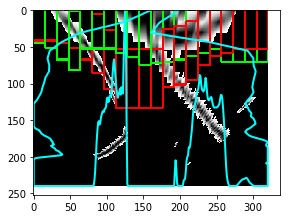

In [391]:
fig = plt.figure(figsize=(15, 10))
local_paths = img_paths[2:3]

i = 1
total = len(local_paths)
cols = 3
for img_path in local_paths:
    print(img_path)
    a = fig.add_subplot((total/cols)+1, cols, i)
    img_raw = cv2.imread(img_path)
    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

    warped = preprocess(img_raw, mtx, dist, M)
    finder = FindLinesSlidingWindows(window_minpix=50, subsequent_search_margin=40,
                                     always_recalculate=True, debug=True)
    lines = finder.process(warped)
#     final_img = annotate_with_lines(warped, lines)
#     plt.imshow(final_img, cmap='gray')

    i += 1

test_images/yellow2.jpg
l error: 218124
r error: None
Red: left, Green: right


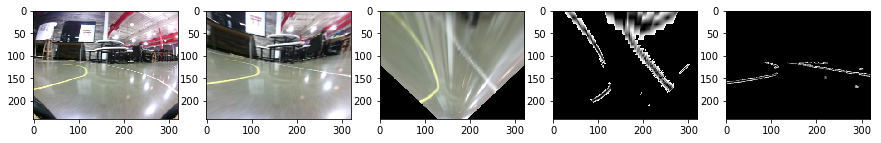

In [372]:
fig = plt.figure(figsize=(15, 30))
local_paths = img_paths[2:3]

i = 1
total = len(local_paths)*5
cols = 5
for img_path in local_paths:
    print(img_path)
    img_raw = cv2.imread(img_path)
    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(undist, M, img_size)

    # Display the original, undistorted, and warped image
    a = fig.add_subplot((total/cols)+1, cols, i)
    plt.imshow(img)
    i+=1
    a = fig.add_subplot((total/cols)+1, cols, i)
    plt.imshow(undist)
    i+=1
    a = fig.add_subplot((total/cols)+1, cols, i)
    plt.imshow(warped)
    i+=1
    
    # Find lines
    a = fig.add_subplot((total/cols)+1, cols, i)
    finder = FindLinesSlidingWindows(window_minpix=50, subsequent_search_margin=50,
                                     always_recalculate=True, debug=False)
    preprocessed = preprocess(img_raw, mtx, dist, M)
    lines = finder.process(preprocessed)
    final_img = annotate_with_lines(preprocessed, lines, keep_background=True)
    plt.imshow(final_img)
    i += 1
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    a = fig.add_subplot((total/cols)+1, cols, i)
    final_img = cv2.warpPerspective(final_img, Minv, (final_img.shape[1], final_img.shape[0]))
    plt.imshow(final_img)
    i += 1

In [308]:
fig = plt.figure(figsize=(15, 10))

i = 1
total = len(img_paths)
cols = 3
for img_path in img_paths:
    print(img_path)
#     ax = fig.add_subplot(rows, cols, i)
    img_raw = cv2.imread(img_path)
    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

    warped = preprocess(img_raw)
    a = fig.add_subplot((total/cols)+1, cols, i)
    finder = FindLinesSlidingWindows(always_recalculate=True)
    lines = finder.process(warped)
    final_img = annotate_with_lines(warped, lines)
#     a = fig.add_subplot((total/cols*2)+1, cols, i)
#     plt.imshow(final_img, cmap='gray')

    i += 1

test_images/blue2.jpg


TypeError: preprocess() missing 3 required positional arguments: 'mtx', 'dist', and 'M'

In [ ]:
import cv2
import numpy as np

img = cv2.imread('test_images/green2.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,130,apertureSize = 3)
minLineLength = 10
maxLineGap = 5
lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
for x1,y1,x2,y2 in lines[0]:
    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

plt.imshow(img)